# Neural Style Transfer

## Introduction

In this project, I will be exploring Gatys _et. al_'s [**A Neural Algorithm of Artistic Style**](). The concept of neural style transfer is a recent research that merges the field of art and neural networks. It takes a white noise image and outputs a new image in the style of a specific artwork (or image). The paper contains multiple examples of what neural style transfer is capable of (see figure 2).

## Project overview
The idea of this project is to recreate Gatys _et. al_'s results in their paper using the PyTorch framework. I will go over some of the key concepts that this paper discusses and write its implementation. My goal is to explore an entirely new type of dataset: from sequences of data to images. Also, this is my first exploration of a _generative model_ - a type of models that synthesizes new data (e.g., an image).

## Key concepts
In this paper, Gatys _et. al_ talks about their usage of convolutional neural networks (CNN) trained for object recognition. Since they are using a pretrained CNN (e.g., VGG-Network), then the goal is to use the features that it has learned from the ImageNet dataset and train it as to generate new images.

As described earlier, the model takes in two source images: content and style images. A **content image** contains the global arrangements of the objects. Meanwhile, the **style image** will be used to extract the textures and colours to be applied to the content image.

One of the goals of neural style transfer is to ensure that while the model is using the style from a style image it should be able to maintain the global arrangements of objects from the content image. In order to know how well the model is doing in keeping these global arrangements, a **content loss function** is calculated as part of the model's style transfer loss. It is simply the mean-squared error of the activations of some white noise image and the content image in the model.

Another goal of neural style transfer is to extract the textures and colours from the style image. So, a **style loss function** is used to achieved this goal. This loss function requires to determine the correlations of each activation along the model's layers. This is achieved by creating **gram matrices** - the dot product of a vector and its tranpose. So the style loss function calculates the mean-squared error of the gram matrices of a white noise image and the content image.

To calculate the **style transfer loss**, the content loss and style losses are added together. Note that there are a couple of parameters (alpha and beta) which controls how much content is preserved and how much style is added to the synthesized image, respectively.

## Approach
I will be considering a pair of content and style images. I will resize them accordingly. Then, I will use the VGG-network as CNN architecture to synthesize the final image. Next, the content and style loss functions will be written. Finally, these loss functions will be combined to output the style transfer loss and create new images.

### Imports
Here are some of the frameworks that will be used in this project:

In [1]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Let's set the device to use based on the existence of a CUDA-enabled GPU or not.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1) Content and style images
Here are the paths for the content and style images:

In [3]:
CONTENT_IMG_PATH = "img/content-image.jpg"
STYLE_IMG_PATH = "img/style-image-2.jpg"

Let's write a helper function to help us visualize our images.

In [4]:
def show_image(img, title=None):
    """Shows the image with its given title
    
    Args:
        img: An image of Image instance
        title: The title to include in the plot
    """
    plt.clf()
    
    if title is not None:
        plt.title(title)
        
    plt.imshow(img)
    plt.tight_layout()

This is what our content image looks like:

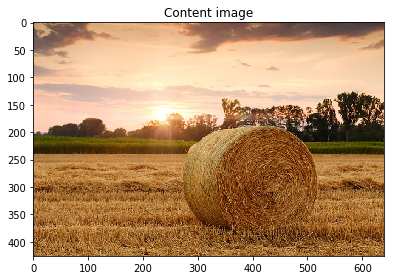

In [5]:
content_img = Image.open(CONTENT_IMG_PATH)
show_image(content_img, title="Content image")

And here's our style image that we will be using to synthesize a new image in this style:

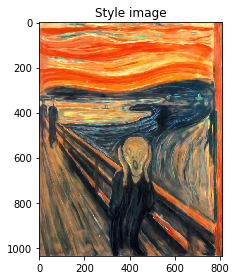

In [6]:
style_img = Image.open(STYLE_IMG_PATH)
show_image(style_img, title="Style image")

Since the images I have downloaded from [Pixabay](https://pixabay.com) do not have the same dimensions, I will be resizing them. Specifically, I will be resizing them to the dimensions **224x224**. This is similar to the input dimensions used for a pretrained `VGG19` CNN architecture that we will be using.

In [7]:
RESIZED_DIMS = (224, 224)

Also, we will need to normalize our image since the pretrained network is trained on images normalized by the following mean and standard deviation values:

In [8]:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD_DEV = [0.229, 0.224, 0.225]

Now, let's write a function that will perform the resizing and normalizing of our images.

In [9]:
def preprocess_image(img, dims=RESIZED_DIMS, mean=NORM_MEAN, std_dev=NORM_STD_DEV):
    """Resizes and normalizes the image and converts it to a tensor
    
    Args:
        img: An Image instance that needs to be resized and converted to a tensor
        dims: The dimensions to resize the image to
        mean: The mean to use when normalizing the image
        std_dev: The standard deviation to use when normalizing the image
        
    Returns:
        The preprocessed image tensor
    """
    img_transforms = transforms.Compose([transforms.Resize(RESIZED_DIMS), transforms.ToTensor(), transforms.Normalize(mean=mean, std=std_dev)])
    img_tensor = img_transforms(img).unsqueeze(0)
    
    return img_tensor.to(device, torch.float)

In our function above, I utilize the `transforms` module to compose a series of transformations such that it resizes the given image and converts it to a tensor that our model will understand (thanks to PyTorch's [neural style transfer tutorial](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)).

In preparation for training the model later, adding a batch dimension (via the `unsqueeze(0)` function) will allow the CNN model to take in our content and style images as if they are part of a batch of input images which has a size of 1.

Lastly, placing our tensor to the proper device with a `torch.float` type ensures that our resized images will work seamlessly with the chosen device.

In [10]:
content_img_tensor = preprocess_image(content_img, RESIZED_DIMS)
style_img_tensor = preprocess_image(style_img, RESIZED_DIMS)

Before we can actually see how the resized images look like, we will have to create an instance of the `ToPILImage` class to convert our tensor to PIL's `Image`s.

In [11]:
pil_image_converter = transforms.ToPILImage()

content_img = pil_image_converter(content_img_tensor.cpu().squeeze(0))
style_img = pil_image_converter(style_img_tensor.cpu().squeeze(0))

Now, let's see how our preprocessed images look like.

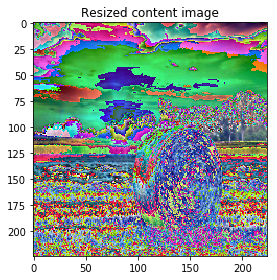

In [12]:
show_image(content_img, title="Resized content image")

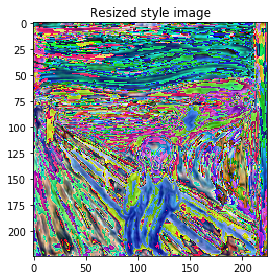

In [13]:
show_image(style_img, title="Resized style image")

### 2) `VGG19` model architecture
From the paper, Gatys et. al used the [VGG network](https://arxiv.org/abs/1409.1556v6) as their pretrained CNN. The VGG network paper focuses about the idea of increasing the depth of CNN architecture to achieve high performance object recognition models. This network has been submitted to the ImageNet Large Scale Visual Recognition Competition in 2014.

With a pretrained model like this, we can take advantage of what it has learned from the ImageNet dataset and have the ability to extract global arrangements as well as texture and colours from our content and style images, respectively.


In [14]:
vgg_19_model = models.vgg19(pretrained=True).to(device).eval()

Based on the paper, Gatys et. al used `conv4_2` as the only layer for content loss and layers `conv1_1`, `conv2_1`, `conv3_1`, `conv4_1`, and `conv5_1` for the style loss. As a result, we will need to gather the features maps for these layers from our content and style images, respectively. Then, start calculating the loss for those layers with our input image.

Firstly, let's figure out a way on how we can extract the feature maps at specific points of our `vgg_19_model`. In order to accomplish this, we can add a lambda function to be hooked to the forward pass of our model. This can be easily done by using the `register_forward_hook()` on our model.

In [15]:
class ModelLayerHooks():
    output = None
    
    def __init__(self, model, layer_index):
        for index, child in enumerate(model.features.children()):
            if index == layer_index:
                self.hook = child.register_forward_hook(self.forward_hook)
                
    def forward_hook(self, module, input, output):
        """Handles the hook when running through the model
        
        Args:
            module: The current module
            input: The input for that current module
            output: The output for that current module
        """
        self.output = output
        
    def remove_hook(self):
        """Removes the forward hook from the layer"""
        self.hook.remove()

A list of layer indices of interest are defined based on the paper.

In [16]:
CONTENT_LAYER_INDEX = [9]
STYLE_LAYER_INDICES = [0, 2, 4, 8, 12]

Before creating our hooks, let's define the content and style losses.

### 3) Content loss

We need to define a class that will calculate the content loss between our input image and content image. This is defined as the mean-squared error between the input and content images feature maps at a specific layer.

In [17]:
def content_loss(input_feature_map, target_feature_map):
    """Calculates the content loss between the input's feature map and the target's feature map
    
    Args:
        input_feature_map: The input image's feature map
        target_feature_map: The target image's feature map
    """
    target_feature_map = target_feature_map.detach()
    
    return F.mse_loss(input_feature_map, target_feature_map)

### 4) Style loss

Before we can calculate the style loss, we need to find how each feature maps correlate with each other. A _gram matrix_ is defined as the matrix multiplication of a feature map $X$ and its tranpose, $X^{T}$. Let's define a helper function to calculate the gram matrix.

In [18]:
def calculate_gram_matrix(X):
    """Calculates the gram matrix for a given feature map
    
    Args:
        X: The feature map matrix
        
    Returns:
        The gram matrix of the feature map
    """
    batch, feature_map, height, width = X.size()
    
    X = X.view(batch * feature_map, height * width)
    X_gram = torch.mm(X, X.t()).div(batch * feature_map * height * width)
    
    return X_gram

Now we can use the gram matrix to calculate the mean-squared error loss - which is the definition of style loss.

In [19]:
def style_loss(input_feature_map, target_feature_map):
    """Calculates the style loss between the input feature map and target feature map
    
    Args:
        input_feature_map: The input feature map
        target_feature_map: The target feature map
        
    Returns:
        The style loss between input and target feature maps
    """
    input_gram = calculate_gram_matrix(input_feature_map)
    target_gram = calculate_gram_matrix(target_feature_map.detach())
    
    return F.mse_loss(input_gram, target_gram)

### 5) Get target feature maps

We need to get the feature maps from our specified layers using our hooks for content and style losses.

In [20]:
content_hooks = [ModelLayerHooks(vgg_19_model, index) for index in CONTENT_LAYER_INDEX]
style_hooks = [ModelLayerHooks(vgg_19_model, index) for index in STYLE_LAYER_INDICES]

vgg_19_model(content_img_tensor)
target_content = [hook.output.clone() for hook in content_hooks]

vgg_19_model(style_img_tensor)
target_style = [hook.output.clone() for hook in style_hooks]

### 6) Create optimizer

Next, we need to create our optimizer. According to PyTorch's tutorial for neural style transfer, Gatys recommended to use the **LBFGS** optimizer. Let's go ahead and use that.

In [21]:
def create_optimizer(input_image_tensor):
    """Creates the LBFGS optimizer and optimizes the pixesl of the input
    
    Args:
        input_image_tensor: The input image to optimize
        
    Returns:
        The optimizer
    """
    return optim.LBFGS([input_image_tensor.requires_grad_()])

One thing to note here is that we are not optimizing our model's parameters. In neural style transfer, we want to optimize the pixels of our input image. This ensures that combination of content and style is maintained in the final image.

### 7) Denormalize image
First, let's create a denormalization function that reverses the normalization performed by `preprocess_image()`.

In [22]:
def denormalize_image(image_tensor, mean=NORM_MEAN, std_dev=NORM_STD_DEV):
    """Denormalizes the image using the mean and standard deviation
    
    Args:
        image_tensor: The image tensor to denormalize
        mean: The mean to use to denormalize the image
        std_dev: The standard deviation to use to denormalize the image
        
    Return:
        The denormalized image tensor
    """
    mean = torch.tensor(mean).view(-1, 1, 1)
    std_dev = torch.tensor(std_dev).view(-1, 1, 1)
    
    return input_img_tensor.cpu().squeeze(0) * std_dev + mean

### 8) Perform content transfer
Before running neural style transfer, let's ensure that content transfer works as expected.

Let's create our white noise image:

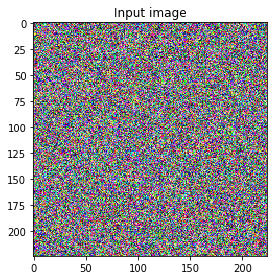

In [23]:
input_img_tensor = torch.randn(content_img_tensor.size(), device=device)
input_img = pil_image_converter(input_img_tensor.cpu().squeeze(0))

input_img_tensor = preprocess_image(input_img)
input_img = pil_image_converter(input_img_tensor.cpu().squeeze(0))
show_image(input_img, title="Input image")

Time to convert the white noise image to the content image.

In [24]:
NUM_EPOCHS = 300
ALPHA = 50
index = 0

optimizer = create_optimizer(input_img_tensor)

print("Content transfer in progress...\n")

while index < NUM_EPOCHS:
    index += 1
    print_loss = index % 50 == 0

    if print_loss:
        print(f"[Content Transfer - Epoch {index}] started")

    def optimizer_closure():
        """Calculates the content loss for the optimizer to use

        Returns:
            The content loss
        """
        optimizer.zero_grad()

        vgg_19_model(input_img_tensor)

        input_content = [hook.output for hook in content_hooks]
        total_content_loss = 0

        for input, target in zip(input_content, target_content):
            total_content_loss += content_loss(input, target)

        total_content_loss *= ALPHA
        total_content_loss.backward()

        return total_content_loss

    loss = optimizer.step(optimizer_closure)

    if print_loss:
        print("Content loss: {:.3f}".format(loss.item()))
        print(f"[Content Transfer - Epoch {index}] ended\n")
        
print("Content transfer done!")

Content transfer in progress...

[Content Transfer - Epoch 50] started
Content loss: 5.687
[Content Transfer - Epoch 50] ended

[Content Transfer - Epoch 100] started
Content loss: 5.104
[Content Transfer - Epoch 100] ended

[Content Transfer - Epoch 150] started
Content loss: 4.952
[Content Transfer - Epoch 150] ended

[Content Transfer - Epoch 200] started
Content loss: 4.860
[Content Transfer - Epoch 200] ended

[Content Transfer - Epoch 250] started
Content loss: 4.796
[Content Transfer - Epoch 250] ended

[Content Transfer - Epoch 300] started
Content loss: 4.747
[Content Transfer - Epoch 300] ended

Content transfer done!


Let's see how the `input_img_tensor` looks like.

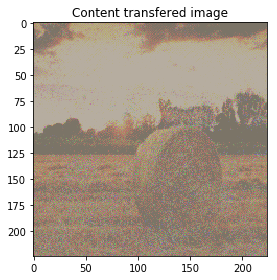

In [25]:
input_img_tensor = input_img_tensor.data.clamp(0, 1).squeeze(0)
input_img_tensor = denormalize_image(input_img_tensor)
input_img = pil_image_converter(input_img_tensor)
show_image(input_img, title="Content transfered image")

### 9) Perform style transfer
Now, let's see if we can properly extract the textures and colours from the style image to the white noise image.

In [26]:
BETA = 1e6

input_img_tensor = torch.randn(content_img_tensor.size(), device=device)
input_img = pil_image_converter(input_img_tensor.cpu().squeeze(0))
input_img_tensor = preprocess_image(input_img)

optimizer = create_optimizer(input_img_tensor)
index = 0

print("Style transfer in progress...\n")

while index < NUM_EPOCHS:
    index += 1
    print_loss = index % 50 == 0
    
    if print_loss:
        print(f"[Style Transfer - Epoch {index}] started")
        
    def optimizer_closure():
        """Calculates the style transfer loss
        
        Returns:
            The style transfer loss
        """
        optimizer.zero_grad()
        
        vgg_19_model(input_img_tensor)
        
        input_style = [hook.output for hook in style_hooks]
        total_style_loss = 0
        
        for input, target in zip(input_style, target_style):
            total_style_loss += style_loss(input, target)
            
        total_style_loss *= BETA
        
        total_style_loss.backward()
        
        return total_style_loss
    
    loss = optimizer.step(optimizer_closure)
        
    if print_loss:
        print("Style loss: {:.3f}".format(loss))
        print(f"[Style Transfer - Epoch {index}] ended\n")
        
print("Style transfer done!")

Style transfer in progress...

[Style Transfer - Epoch 50] started
Style loss: 0.200
[Style Transfer - Epoch 50] ended

[Style Transfer - Epoch 100] started
Style loss: 0.142
[Style Transfer - Epoch 100] ended

[Style Transfer - Epoch 150] started
Style loss: 0.131
[Style Transfer - Epoch 150] ended

[Style Transfer - Epoch 200] started
Style loss: 0.127
[Style Transfer - Epoch 200] ended

[Style Transfer - Epoch 250] started
Style loss: 0.124
[Style Transfer - Epoch 250] ended

[Style Transfer - Epoch 300] started
Style loss: 0.122
[Style Transfer - Epoch 300] ended

Style transfer done!


Let's see how the style transfered image looks like.

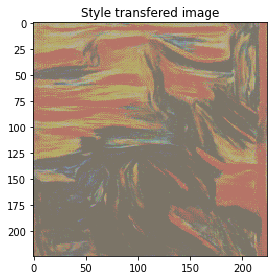

In [27]:
input_img_tensor = input_img_tensor.data.clamp(0, 1).squeeze(0)
input_img_tensor = denormalize_image(input_img_tensor)
input_img = pil_image_converter(input_img_tensor)
show_image(input_img, title="Style transfered image")

### 8) Putting it all together
Finally, let's perform the neural style transfer.

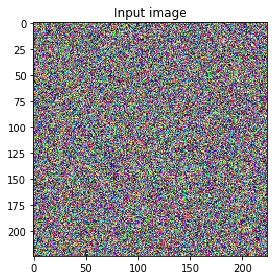

In [28]:
input_img_tensor = torch.randn(content_img_tensor.size(), device=device)
input_img = pil_image_converter(input_img_tensor.cpu().squeeze(0))

input_img_tensor = preprocess_image(input_img)
input_img = pil_image_converter(input_img_tensor.cpu().squeeze(0))
show_image(input_img, title="Input image")

In [29]:
def run_neural_transfer(input_img_tensor):
    """Runs a neural transfer on the given input image tensor
    
    Args:
        input_img_tensor: The input image tensor to perform neural style transfer on
        
    Returns:
        The optimized input image tensor
    """
    optimizer = create_optimizer(input_img_tensor)
    index = 0

    print("Neural style transfer in progress...\n")

    while index < NUM_EPOCHS:
        index += 1
        print_loss = index % 50 == 0

        if print_loss:
            print(f"[Neural style transfer - Epoch {index}] started")

        def optimizer_closure():
            """Calculates the neural style transfer loss

            Returns:
                The neural style transfer loss
            """
            optimizer.zero_grad()

            vgg_19_model(input_img_tensor)

            input_content = [hook.output for hook in content_hooks]
            input_style = [hook.output for hook in style_hooks]

            total_content_loss = 0
            total_style_loss = 0

            for input, target in zip(input_content, target_content):
                total_content_loss += content_loss(input, target)

            for input, target in zip(input_style, target_style):
                total_style_loss += style_loss(input, target)

            total_content_loss *= ALPHA
            total_style_loss *= BETA

            combined_loss = total_content_loss + total_style_loss

            combined_loss.backward()

            return combined_loss

        loss = optimizer.step(optimizer_closure)

        if print_loss:
            print("Neural style transfer loss: {:.3f}".format(loss))
            print(f"[Neural style transfer - Epoch {index}] ended\n")

    print("Neural style transfer done!")
    
    return input_img_tensor.data.clamp(0, 1)

Let's perform the neural style transfer to our input image.

Neural style transfer in progress...

[Neural style transfer - Epoch 50] started
Neural style transfer loss: 216.110
[Neural style transfer - Epoch 50] ended

[Neural style transfer - Epoch 100] started
Neural style transfer loss: 211.714
[Neural style transfer - Epoch 100] ended

[Neural style transfer - Epoch 150] started
Neural style transfer loss: 210.121
[Neural style transfer - Epoch 150] ended

[Neural style transfer - Epoch 200] started
Neural style transfer loss: 209.281
[Neural style transfer - Epoch 200] ended

[Neural style transfer - Epoch 250] started
Neural style transfer loss: 208.754
[Neural style transfer - Epoch 250] ended

[Neural style transfer - Epoch 300] started
Neural style transfer loss: 208.368
[Neural style transfer - Epoch 300] ended

Neural style transfer done!


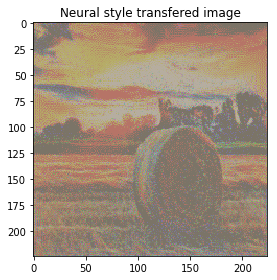

In [30]:
input_img_tensor = run_neural_transfer(input_img_tensor).squeeze(0)
input_img_tensor = denormalize_image(input_img_tensor)
input_img = pil_image_converter(input_img_tensor)
show_image(input_img, title="Neural style transfered image")

### 9) Test with own image
Now let's test this with our own content image.

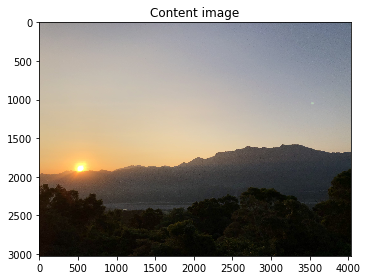

In [31]:
CONTENT_IMG2_PATH = "img/content-image-2.jpg"

content_img2 = Image.open(CONTENT_IMG2_PATH)
show_image(content_img2, title="Content image")

Next let's preprocess the content image.

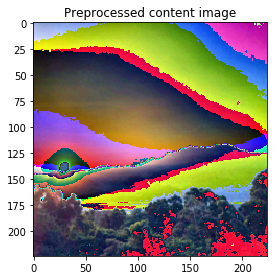

In [32]:
content_img2_tensor = preprocess_image(content_img2)
content_img2 = pil_image_converter(content_img2_tensor.detach().cpu().squeeze(0))
show_image(content_img2, title="Preprocessed content image")

Next, we will have to recalculate the content outputs for our new content image.

In [33]:
vgg_19_model(content_img2_tensor)
target_content = [hook.output.clone() for hook in content_hooks]

Now we can perform the neural style transfer with our new content image.

In [34]:
input_img_tensor = torch.randn(content_img2_tensor.size(), device=device)
input_img = pil_image_converter(input_img_tensor.cpu().squeeze(0))
input_img_tensor = preprocess_image(input_img)

Neural style transfer in progress...

[Neural style transfer - Epoch 50] started
Neural style transfer loss: 320.060
[Neural style transfer - Epoch 50] ended

[Neural style transfer - Epoch 100] started
Neural style transfer loss: 313.949
[Neural style transfer - Epoch 100] ended

[Neural style transfer - Epoch 150] started
Neural style transfer loss: 311.634
[Neural style transfer - Epoch 150] ended

[Neural style transfer - Epoch 200] started
Neural style transfer loss: 310.357
[Neural style transfer - Epoch 200] ended

[Neural style transfer - Epoch 250] started
Neural style transfer loss: 309.516
[Neural style transfer - Epoch 250] ended

[Neural style transfer - Epoch 300] started
Neural style transfer loss: 308.909
[Neural style transfer - Epoch 300] ended

Neural style transfer done!


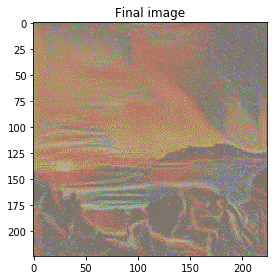

In [35]:
input_img_tensor = run_neural_transfer(input_img_tensor).squeeze(0)
input_img_tensor = denormalize_image(input_img_tensor)
input_img = pil_image_converter(input_img_tensor)
show_image(input_img, title="Final image")

Finally, close all the forward hooks.

In [36]:
for hook in content_hooks:
    hook.remove_hook()

for hook in style_hooks:
    hook.remove_hook()